# Machine Learning

## Import libraries and create Dataframe

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

from google.colab import drive
drive.mount('/content/drive')

# Load the combined table we created in the previous Data Cleaning section
df = pd.read_csv('/content/drive/MyDrive/Tobacco Project/Cleaned data/CombinedDF.csv', index_col=0)
df = df.drop(['Objectives exist', 'Ntl agency exists', 'No. staff', 'Monitor'], axis=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Feature Encoding

In [ ]:
# Ordinal Encoding for Income Group, specifying the order

oe = OrdinalEncoder(categories=[['LIC', 'LMIC', 'UMIC', 'HIC']])
df['Income Group'] = oe.fit_transform(df[['Income Group']])

# One Hot Encoding our Continent data

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop="first", sparse_output=False)
cat = ['Continental Classification']
encoded_data = ohe.fit_transform(df[cat])
feature_names = ohe.get_feature_names_out(cat)
encoded_df = pd.DataFrame(encoded_data, columns=feature_names, index=df.index)
df = pd.concat([df, encoded_df], axis=1)
df = df.drop(columns=cat)

# Target encoding our Region data
df["region_encoded"] = df.groupby("Region")["Overall use"].transform("mean")

## Train Model Function

In [ ]:
def train_model(df, target_column, model, drop_columns=None, test_size=0.2, random_state=42, return_splits=False):

    # 1. Ensure reproducibility
    np.random.seed(random_state)

    # 2. Prepare the features (X) and target (y)
    X = df.drop(columns=drop_columns + [target_column]) if drop_columns else df.drop(columns=[target_column])
    y = df[target_column]

    # 3. Train-test split with group stratification (based on the 'Region')
    splitter = GroupShuffleSplit(test_size=test_size, random_state=random_state)
    for train_idx, test_idx in splitter.split(X, y, groups=df['Region']):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    X_train = X_train.drop(columns=['Region'])
    X_test = X_test.drop(columns=['Region'])

    # 4. Scaling the features using StandardScaler
    # Scaling Ordinal and One Hot Encoded columns is not necessary, but our models run identically whether they are scaled or not.
    # So all columns are scaled for the sake of simplicity.
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    # 5. Train the specified model
    model.fit(X_train, y_train)

    # 6. Make predictions
    pred_test = model.predict(X_test)
    pred_train = model.predict(X_train)

    # 7. Calculate Mean Absolute Error for train and test sets
    test_mae = mean_absolute_error(y_test, pred_test)
    train_mae = mean_absolute_error(y_train, pred_train)

    # 8. Allow Linear Regression coefficient scores to be retrieved
    if isinstance(model, LinearRegression):
        coefficients = pd.Series(model.coef_, X_train.columns)
        coefficients = coefficients.sort_values(key=abs, ascending=False)
    else:
        coefficients = None

    # 9. Allow the retrieval of MAE values and Linear Regression coefficients, and optionally the test train split sets if required
    if return_splits:
        return test_mae, train_mae, coefficients, X_train, X_test, y_train, y_test
    else:
        return test_mae, train_mae, coefficients

## Initial Models

In [ ]:
from sklearn.linear_model import LinearRegression

lrtest, lrtrain, coeff, X_train_region, X_test_region, y_train_region, y_test_region = train_model(df, target_column='Overall use',
                                                 model=LinearRegression(),
                                                 drop_columns=['Male', 'Female', 'Non_age_standardised_tobacco_use', 'Male(Non_age_standardised_tobacco_use)', 'Female(Non_age_standardised_tobacco_use)'],
                                                                       return_splits=True)
print(f"Linear Regression Test MAE: {lrtest:.2f}")
print(f"Linear Regression Train MAE: {lrtrain:.2f}")
print("\n")

# z is used as a placeholder, because coefficients returns None if the model is not Linear Regression
dtrtest, dtrtrain, z = train_model(df, target_column='Overall use',
                                                 model=DecisionTreeRegressor(),
                                                 drop_columns=['Male', 'Female', 'Non_age_standardised_tobacco_use', 'Male(Non_age_standardised_tobacco_use)', 'Female(Non_age_standardised_tobacco_use)'])

print(f"DecisionTreeRegressor Test MAE: {dtrtest:.2f}")
print(f"DecisionTreeRegressor Train MAE: {dtrtrain:.2f}")
print("\n")

from sklearn.ensemble import RandomForestRegressor

rfrtest, rfrtrain, z = train_model(df, target_column='Overall use',
                                                 model=RandomForestRegressor(),
                                                 drop_columns=['Male', 'Female', 'Non_age_standardised_tobacco_use', 'Male(Non_age_standardised_tobacco_use)', 'Female(Non_age_standardised_tobacco_use)'])

print(f"RandomForestRegressor Test MAE: {rfrtest:.2f}")
print(f"RandomForestRegressor Train MAE: {rfrtrain:.2f}")

Linear Regression Test MAE: 1.09
Linear Regression Train MAE: 1.02


DecisionTreeRegressor Test MAE: 1.61
DecisionTreeRegressor Train MAE: 0.00


RandomForestRegressor Test MAE: 1.22
RandomForestRegressor Train MAE: 0.24


## Leave One Out Encoding

In [ ]:
!pip install category_encoders --quiet
import category_encoders as ce
loo_encoder = ce.LeaveOneOutEncoder(cols=['Region'])
df['region_encoded'] = loo_encoder.fit_transform(df['Region'], df['Overall use'])

lrtest, lrtrain, coeff = train_model(df, target_column='Overall use',
                                                 model=LinearRegression(),
                                                 drop_columns=['Male', 'Female', 'Non_age_standardised_tobacco_use', 'Male(Non_age_standardised_tobacco_use)', 'Female(Non_age_standardised_tobacco_use)'])
print(f"Linear Regression Test MAE LOO Encoded: {lrtest:.2f}")
print(f"Linear Regression Train MAE LOO Encoded {lrtrain:.2f}")
print("\n")
print("Coefficient values LOO Encoded:")
print(coeff)

Linear Regression Test MAE LOO Encoded: 1.25
Linear Regression Train MAE LOO Encoded 1.17


Coefficient values LOO Encoded:
region_encoded                                           9.710852
Year                                                    -1.984849
risk_warning                                            -0.277843
Continental Classification_Sub-Saharan Africa           -0.149737
advertisement_ban                                        0.138366
tax_increase                                             0.093875
Continental Classification_Middle East & North Africa   -0.091286
Income Group                                            -0.047174
Continental Classification_Latin America & Caribbean    -0.046084
cessation_support                                        0.042663
Continental Classification_South Asia                   -0.026657
exposure_protect                                        -0.025401
Continental Classification_Europe & Central Asia        -0.019653
Continental Classi

## Modelling without Region

In [ ]:
df = df.drop(columns=['region_encoded'])

from sklearn.linear_model import LinearRegression

lrtest, lrtrain, coeff, X_train2, X_test2, y_train2, y_test2 = train_model(df, target_column='Overall use',
                                                 model=LinearRegression(),
                                                 drop_columns=['Male', 'Female', 'Non_age_standardised_tobacco_use', 'Male(Non_age_standardised_tobacco_use)', 'Female(Non_age_standardised_tobacco_use)'],
                                                 return_splits=True)
print(f"Linear Regression Test MAE Without Region: {lrtest:.2f}")
print(f"Linear Regression Train MAE Without Region: {lrtrain:.2f}")
print("\n")
print("Linear Regression Coefficients Without Region:")
print(coeff)
print("\n")

dtrtest, dtrtrain, z = train_model(df, target_column='Overall use',
                                                 model=DecisionTreeRegressor(),
                                                 drop_columns=['Male', 'Female', 'Non_age_standardised_tobacco_use', 'Male(Non_age_standardised_tobacco_use)', 'Female(Non_age_standardised_tobacco_use)'])

print(f"DecisionTreeRegressor Test MAE Without Region: {dtrtest:.2f}")
print(f"DecisionTreeRegressor Train MAE Without Region: {dtrtrain:.2f}")
print("\n")

rfrtest, rfrtrain, z = train_model(df, target_column='Overall use',
                                                 model=RandomForestRegressor(),
                                                 drop_columns=['Male', 'Female', 'Non_age_standardised_tobacco_use', 'Male(Non_age_standardised_tobacco_use)', 'Female(Non_age_standardised_tobacco_use)'])

print(f"RandomForestRegressor Test MAE Without Region: {rfrtest:.2f}")
print(f"RandomForestRegressor Train MAE Without Region: {rfrtrain:.2f}")

Linear Regression Test MAE Without Region: 7.23
Linear Regression Train MAE Without Region: 4.94


Linear Regression Coefficients Without Region:
Continental Classification_Sub-Saharan Africa           -7.103223
Continental Classification_Latin America & Caribbean    -5.480272
Continental Classification_Middle East & North Africa   -2.734843
tax_increase                                             2.507805
Cigarette_price                                         -1.661844
risk_warning                                            -0.864950
media_campaign                                          -0.768506
cessation_support                                       -0.747996
Year                                                    -0.730559
Continental Classification_North America                -0.645513
Continental Classification_South Asia                    0.569810
Income Group                                            -0.490437
Continental Classification_Europe & Central Asia        -0.377

In [ ]:
# Modelling without Region or Continent

df = df.drop(columns=['Continental Classification_Europe & Central Asia',
 'Continental Classification_Latin America & Caribbean',
 'Continental Classification_Middle East & North Africa',
 'Continental Classification_North America',
 'Continental Classification_South Asia',
 'Continental Classification_Sub-Saharan Africa'])

from sklearn.linear_model import LinearRegression

lrtest, lrtrain, coeff, X_train2, X_test2, y_train2, y_test2 = train_model(df, target_column='Overall use',
                                                 model=LinearRegression(),
                                                 drop_columns=['Male', 'Female', 'Non_age_standardised_tobacco_use', 'Male(Non_age_standardised_tobacco_use)', 'Female(Non_age_standardised_tobacco_use)'],
                                                 return_splits=True)
print(f"Linear Regression Test MAE Without Region or Continent: {lrtest:.2f}")
print(f"Linear Regression Train MAE Without Region or Continent: {lrtrain:.2f}")
print("\n")
print("Linear Regression Coefficients Without Region or Continent:")
print(coeff)
print("\n")

dtrtest, dtrtrain, z = train_model(df, target_column='Overall use',
                                                 model=DecisionTreeRegressor(),
                                                 drop_columns=['Male', 'Female', 'Non_age_standardised_tobacco_use', 'Male(Non_age_standardised_tobacco_use)', 'Female(Non_age_standardised_tobacco_use)'])

print(f"DecisionTreeRegressor Test MAE Without Region or Continent: {dtrtest:.2f}")
print(f"DecisionTreeRegressor Train MAE Without Region or Continent: {dtrtrain:.2f}")
print("\n")

rfrtest, rfrtrain, z = train_model(df, target_column='Overall use',
                                                 model=RandomForestRegressor(),
                                                 drop_columns=['Male', 'Female', 'Non_age_standardised_tobacco_use', 'Male(Non_age_standardised_tobacco_use)', 'Female(Non_age_standardised_tobacco_use)'])

print(f"RandomForestRegressor Test MAE Without Region or Continent: {rfrtest:.2f}")
print(f"RandomForestRegressor Train MAE Without Region or Continent: {rfrtrain:.2f}")


Linear Regression Test MAE Without Region or Continent: 7.94
Linear Regression Train MAE Without Region or Continent: 7.21


Linear Regression Coefficients Without Region or Continent:
tax_increase         2.977190
Income Group         1.917940
Year                -1.910367
advertisement_ban    1.566132
cessation_support   -1.061565
Cigarette_price     -0.718536
exposure_protect    -0.658598
media_campaign       0.207382
risk_warning        -0.095580
dtype: float64


DecisionTreeRegressor Test MAE Without Region or Continent: 10.50
DecisionTreeRegressor Train MAE Without Region or Continent: 0.00


RandomForestRegressor Test MAE Without Region or Continent: 8.79
RandomForestRegressor Train MAE Without Region or Continent: 1.64


## Models with Female and Male tobacco use as targets

In [ ]:
lrtest, lrtrain, coeff = train_model(df, target_column='Female',
                                                 model=LinearRegression(),
                                                 drop_columns=['Overall use', 'Male', 'Female', 'Non_age_standardised_tobacco_use', 'Male(Non_age_standardised_tobacco_use)', 'Female(Non_age_standardised_tobacco_use)'])
print(f"Linear Regression Test MAE Female: {lrtest:.2f}")
print(f"Linear Regression Train MAE Female: {lrtrain:.2f}")
print("\n")
print("Linear Regression Coefficients Female:")
print(coeff)
print("\n")

lrtest, lrtrain, coeff = train_model(df, target_column='Male',
                                                 model=LinearRegression(),
                                                 drop_columns=['Overall use', 'Male', 'Female', 'Non_age_standardised_tobacco_use', 'Male(Non_age_standardised_tobacco_use)', 'Female(Non_age_standardised_tobacco_use)'])

print(f"Linear Regression Test MAE Male: {lrtest:.2f}")
print(f"Linear Regression Train MAE Male: {lrtrain:.2f}")
print("\n")
print("Linear Regression Coefficients Male:")
print(coeff)

Linear Regression Test MAE Female: 7.44
Linear Regression Train MAE Female: 6.53


Linear Regression Coefficients Female:
tax_increase         3.934207
Income Group         3.493909
cessation_support   -1.800258
advertisement_ban    1.189753
Year                -1.130316
risk_warning        -0.732601
Cigarette_price      0.599469
media_campaign      -0.566377
exposure_protect    -0.532320
dtype: float64


Linear Regression Test MAE Male: 11.46
Linear Regression Train MAE Male: 10.82


Linear Regression Coefficients Male:
Year                -2.688328
Cigarette_price     -2.041510
tax_increase         2.024671
advertisement_ban    1.944016
media_campaign       0.979376
exposure_protect    -0.779620
risk_warning         0.534628
Income Group         0.352737
cessation_support   -0.325757
dtype: float64


## Clusters as an alternative to Region encoding

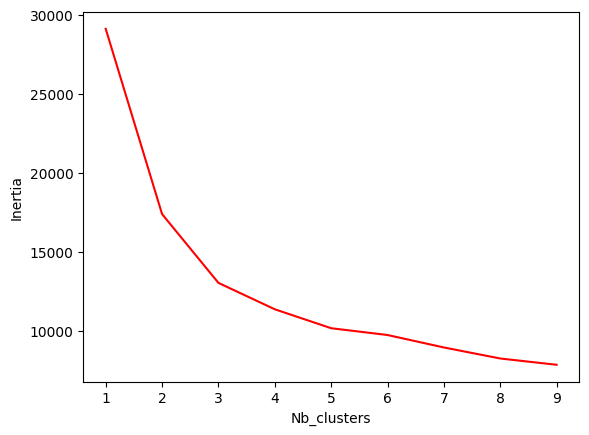

In [ ]:
# Find optimal number of K-means clusters using the elbow method

X_cluster = df[[
 'Cigarette_price',
 'exposure_protect',
 'cessation_support',
 'risk_warning',
 'advertisement_ban',
 'tax_increase',
 'media_campaign',
 'Income Group',]]

from sklearn.cluster import KMeans

L = []

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=40)
    kmeans.fit(X_cluster)
    L.append(kmeans.inertia_)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(1, 10), L, c='red')
plt.xlabel('Nb_clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42) # You can adjust the number of clusters df['Region_Cluster'] = kmeans.fit_predict(X_cluster)
df['Region_Cluster'] = kmeans.fit_predict(X_cluster)

lrtest, lrtrain, coeff = train_model(df, target_column='Overall use',
                                                 model=LinearRegression(),
                                                 drop_columns=['Male', 'Female', 'Non_age_standardised_tobacco_use', 'Male(Non_age_standardised_tobacco_use)', 'Female(Non_age_standardised_tobacco_use)'])
print(f"Linear Regression Test MAE Clusters: {lrtest:.2f}")
print(f"Linear Regression Train MAE Clusters: {lrtrain:.2f}")
print("\n")
print("Linear Regression Coefficients Clusters:")
print(coeff)

Linear Regression Test MAE Clusters: 7.86
Linear Regression Train MAE Clusters: 7.21


Linear Regression Coefficients Clusters:
tax_increase         2.860787
Year                -2.012433
Income Group         1.701359
advertisement_ban    1.544458
cessation_support   -1.095723
Cigarette_price     -0.930814
Region_Cluster       0.703399
exposure_protect    -0.688469
media_campaign       0.197564
risk_warning        -0.071369
dtype: float64


## Time Lag features

In [ ]:
df = df.drop(columns='Region_Cluster')

variables_to_lag = ['Cigarette_price', 'exposure_protect', 'cessation_support', 'risk_warning', 'advertisement_ban', 'tax_increase', 'media_campaign']

# Create lagged variables by shifting 1 row forward (since the data is in 2-year intervals)
for var in variables_to_lag:
    df[f"{var}_t-2"] = df.groupby('Region')[var].shift(1)

df[['Cigarette_price_t-2', 'exposure_protect_t-2', 'cessation_support_t-2', 'risk_warning_t-2', 'advertisement_ban_t-2', 'tax_increase_t-2', 'media_campaign_t-2']] = df[['Cigarette_price_t-2', 'exposure_protect_t-2', 'cessation_support_t-2', 'risk_warning_t-2', 'advertisement_ban_t-2', 'tax_increase_t-2', 'media_campaign_t-2']].bfill(axis=0)

lrtest, lrtrain, coeff = train_model(df, target_column='Overall use',
                                                 model=LinearRegression(),
                                                 drop_columns=['Male', 'Female', 'Non_age_standardised_tobacco_use', 'Male(Non_age_standardised_tobacco_use)', 'Female(Non_age_standardised_tobacco_use)'])
print(f"Linear Regression Test MAE Time Lag: {lrtest:.2f}")
print(f"Linear Regression Train MAE Time Lag: {lrtrain:.2f}")
print("\n")
print("Linear Regression Coefficients Time Lag:")
print(coeff)

Linear Regression Test MAE Time Lag: 7.83
Linear Regression Train MAE Time Lag: 7.15


Linear Regression Coefficients Time Lag:
tax_increase             2.536100
Income Group             2.016999
Year                    -1.958009
advertisement_ban_t-2    1.912774
Cigarette_price         -1.820908
Cigarette_price_t-2      1.109233
cessation_support_t-2   -1.083993
tax_increase_t-2         0.403065
exposure_protect_t-2    -0.350801
exposure_protect        -0.279096
risk_warning_t-2        -0.260728
media_campaign           0.208201
cessation_support       -0.197361
media_campaign_t-2       0.158046
advertisement_ban       -0.155951
risk_warning             0.121118
dtype: float64


## Hyperparameter Optimisation

In [ ]:
#@title RandomForestRegressor Optimisation

df = df.drop(columns=['Cigarette_price_t-2', 'exposure_protect_t-2', 'cessation_support_t-2', 'risk_warning_t-2', 'advertisement_ban_t-2', 'tax_increase_t-2', 'media_campaign_t-2'])

from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Run GridSearch
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search_rf = GridSearchCV(rf, param_grid_rf, scoring='neg_mean_absolute_error', cv=5)
grid_search_rf.fit(X_train2, y_train2)

# Best model
best_rf = grid_search_rf.best_estimator_
pred_test = best_rf.predict(X_test2)
pred_train = best_rf.predict(X_train2)
rf2test = mean_absolute_error(y_test2, pred_test)
rf2train = mean_absolute_error(y_train2, pred_train)

In [ ]:
#@title XGBBoost Optimisation

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 500],  # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1],  # Shrinks contribution of each tree
    'max_depth': [3, 5, 7],  # Limits complexity
    'subsample': [0.8, 1.0],  # Prevents overfitting
    'colsample_bytree': [0.8, 1.0]  # Feature selection per tree
}

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1)

# Run GridSearch
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
grid_search_xgb.fit(X_train2, y_train2)

# Best model
best_xgb = grid_search_xgb.best_estimator_
pred_test = best_xgb.predict(X_test2)
pred_train = best_xgb.predict(X_train2)
xgbtest = mean_absolute_error(y_test2, pred_test)
xgbtrain = mean_absolute_error(y_train2, pred_train)

In [ ]:
#@ Performance comparison

print(f"Linear Regression Test MAE: {lrtest:.2f}")
print(f"Linear Regression Train MAE: {lrtrain:.2f}")
print("\n")
print(f"Random Forest Test MAE: {rfrtest:.2f}")
print(f"Random Forest Train MAE: {rfrtrain:.2f}")
print("\n")
print(f"Random Forest Test MAE tuned: {rf2test:.2f}")
print(f"Random Forest Train MAE tuned: {rf2train:.2f}")
print("\n")
print(f"XGBoost Test MAE: {xgbtest:.2f}")
print(f"XGBoost Train MAE: {xgbtrain:.2f}")

Linear Regression Test MAE: 7.83
Linear Regression Train MAE: 7.15


Random Forest Test MAE: 8.79
Random Forest Train MAE: 1.64


Random Forest Test MAE tuned: 8.65
Random Forest Train MAE tuned: 3.78


XGBoost Test MAE: 8.07
XGBoost Train MAE: 5.48


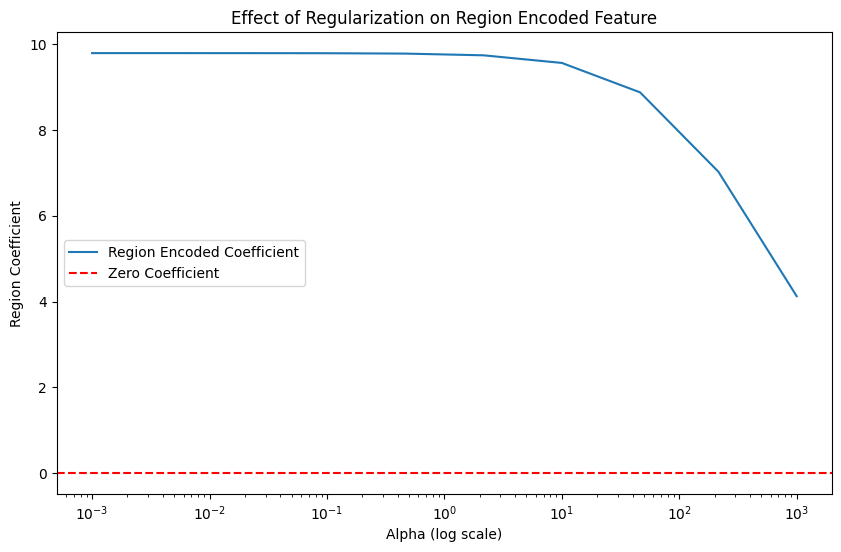

In [ ]:
#@title Ridge Regression model

from sklearn.linear_model import Ridge

alpha_range = np.logspace(-3, 3, 10)  # 10 values between 0.001 and 1000

coefs = []
for alpha in alpha_range:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_region, y_train_region)
    coefs.append(ridge.coef_)

coefs = np.array(coefs)

# Visualise the impact of alpha values on Region Encoded coefficient values
plt.figure(figsize=(10,6))
plt.plot(alpha_range, coefs[:, X_train_region.columns.get_loc("region_encoded")], label="Region Encoded Coefficient")
plt.xscale("log")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Region Coefficient")
plt.axhline(y=0, color="r", linestyle="--", label="Zero Coefficient")
plt.title("Effect of Regularization on Region Encoded Feature")
plt.legend()
plt.show()

## Train model seperately on high and low income countries

In [ ]:
#@title High Income Countries

df_high = df[df['Income Group'] == 3]  # High Income countries

hictest, hictrain, hiccoeff = train_model(df_high, target_column='Overall use',
                                                 model=LinearRegression(),
                                                 drop_columns=['Male', 'Female', 'Non_age_standardised_tobacco_use', 'Male(Non_age_standardised_tobacco_use)', 'Female(Non_age_standardised_tobacco_use)', 'Income Group'])
print(f"Linear Regression Test MAE High Income Countries: {hictest:.2f}")
print(f"Linear Regression Train MAE High Income Countries: {hictrain:.2f}")
print("\n")
print("Linear Regression Coefficients High Income Countries:")
print(hiccoeff)

Linear Regression Test MAE High Income Countries: 5.82
Linear Regression Train MAE High Income Countries: 6.06


Linear Regression Coefficients High Income Countries:
tax_increase         4.365230
Cigarette_price     -2.461182
exposure_protect     1.637996
cessation_support   -1.478672
Year                -0.651652
risk_warning        -0.552940
media_campaign      -0.263637
advertisement_ban    0.116064
dtype: float64


In [ ]:
#@title Low Income Countries

df_low = df[df['Income Group'] == 0]   # Low Income countries

lictest, lictrain, liccoeff = train_model(df_low, target_column='Overall use',
                                                 model=LinearRegression(),
                                                 drop_columns=['Male', 'Female', 'Non_age_standardised_tobacco_use', 'Male(Non_age_standardised_tobacco_use)', 'Female(Non_age_standardised_tobacco_use)', 'Income Group'])
print(f"Linear Regression Test MAE Low Income Countries: {lictest:.2f}")
print(f"Linear Regression Train MAE Low Income Countries: {lictrain:.2f}")
print("\n")
print("Linear Regression Coefficients Low Income Countries:\n", liccoeff)

Linear Regression Test MAE Low Income Countries: 7.01
Linear Regression Train MAE Low Income Countries: 4.20


Linear Regression Coefficients Low Income Countries:
 tax_increase         4.382423
Year                -2.337533
cessation_support   -1.327551
advertisement_ban   -1.309738
Cigarette_price      1.056209
risk_warning         0.411673
media_campaign      -0.371844
exposure_protect     0.224532
dtype: float64


## Train models by continent

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Tobacco Project/Cleaned data/CombinedDF.csv', index_col=0)
df = df.drop(['Objectives exist', 'Ntl agency exists', 'No. staff', 'Monitor', 'Income Group'], axis=1)

df['Continental Classification'].value_counts()

# North America contains too little data, only 16 rows from the US and Canada alone
# Merge North America and Latin America into 'Americas'

df["Continental Classification"] = df["Continental Classification"].replace(
    {"North America": "Americas", "Latin America & Caribbean": "Americas"}
)

In [ ]:
# Seperate Dataframes by continent

sasia = df[df['Continental Classification'] == 'South Asia']
sasia = sasia.drop(['Continental Classification'], axis=1)
euca = df[df['Continental Classification'] == 'Europe & Central Asia']
euca = euca.drop(['Continental Classification'], axis=1)
mena = df[df['Continental Classification'] == 'Middle East & North Africa']
mena = mena.drop(['Continental Classification'], axis=1)
amer = df[df['Continental Classification'] == 'Americas']
amer = amer.drop(['Continental Classification'], axis=1)
eap = df[df['Continental Classification'] == 'East Asia & Pacific']
eap = eap.drop(['Continental Classification'], axis=1)
ssa = df[df['Continental Classification'] == 'Sub-Saharan Africa']
ssa = ssa.drop(['Continental Classification'], axis=1)

In [ ]:
#@title South Asia

sasiatest, sasiatrain, sasiacoeff = train_model(sasia, target_column='Overall use',
                                                 model=LinearRegression(),
                                                 drop_columns=['Male', 'Female', 'Non_age_standardised_tobacco_use', 'Male(Non_age_standardised_tobacco_use)', 'Female(Non_age_standardised_tobacco_use)'])
print(f"Linear Regression Test MAE South Asia: {sasiatest:.2f}")
print(f"Linear Regression Train MAE South Asia: {sasiatrain:.2f}")
print("\n")
print("Coefficient values for South Asia:")
print(sasiacoeff)

Linear Regression Test MAE South Asia: 6.20
Linear Regression Train MAE South Asia: 3.44


Coefficient values for South Asia:
Year                -5.561457
advertisement_ban    2.157496
risk_warning         1.992165
Cigarette_price     -1.310899
exposure_protect    -1.124044
cessation_support    0.600825
media_campaign       0.458871
tax_increase        -0.202318
dtype: float64


In [ ]:
#@title Europe & Central Asia

eucatest, eucatrain, eucacoeff = train_model(euca, target_column='Overall use',
                                                 model=LinearRegression(),
                                                 drop_columns=['Male', 'Female', 'Non_age_standardised_tobacco_use', 'Male(Non_age_standardised_tobacco_use)', 'Female(Non_age_standardised_tobacco_use)'])
print(f"Linear Regression Test MAE Europe & Central Asia: {eucatest:.2f}")
print(f"Linear Regression Train MAE Europe & Central Asia: {eucatrain:.2f}")
print("\n")
print("Coefficient values for Europe & Central Asia:")
print(eucacoeff)

Linear Regression Test MAE Europe & Central Asia: 6.57
Linear Regression Train MAE Europe & Central Asia: 3.96


Coefficient values for Europe & Central Asia:
Cigarette_price     -3.875625
tax_increase         3.057639
advertisement_ban   -1.739935
exposure_protect     1.708921
cessation_support    0.795045
media_campaign      -0.786011
Year                -0.583309
risk_warning        -0.157324
dtype: float64


In [ ]:
#@title Middle East & North Africa

menatest, menatrain, menacoeff = train_model(mena, target_column='Overall use',
                                                 model=LinearRegression(),
                                                 drop_columns=['Male', 'Female', 'Non_age_standardised_tobacco_use', 'Male(Non_age_standardised_tobacco_use)', 'Female(Non_age_standardised_tobacco_use)'])
print(f"Linear Regression Test MAE Middle East & North Africa: {menatest:.2f}")
print(f"Linear Regression Train MAE Middle East & North Africa: {menatrain:.2f}")
print("\n")
print("Coefficient values for Middle East & North Africa:")
print(menacoeff)

Linear Regression Test MAE Middle East & North Africa: 5.47
Linear Regression Train MAE Middle East & North Africa: 4.10


Coefficient values for Middle East & North Africa:
risk_warning        -3.570650
tax_increase         3.226444
exposure_protect     3.085111
cessation_support    2.752291
Cigarette_price     -2.106776
Year                 0.837105
advertisement_ban    0.535484
media_campaign      -0.212098
dtype: float64


In [ ]:
#@title Americas

amertest, amertrain, amercoeff = train_model(amer, target_column='Overall use',
                                                 model=LinearRegression(),
                                                 drop_columns=['Male', 'Female', 'Non_age_standardised_tobacco_use', 'Male(Non_age_standardised_tobacco_use)', 'Female(Non_age_standardised_tobacco_use)'])
print(f"Linear Regression Test MAE Americas: {amertest:.2f}")
print(f"Linear Regression Train MAE Americas: {amertrain:.2f}")
print("\n")
print("Coefficient values for Americas:")
print(amercoeff)

Linear Regression Test MAE Americas: 5.69
Linear Regression Train MAE Americas: 4.66


Coefficient values for Americas:
tax_increase         3.509891
exposure_protect    -2.142104
risk_warning         1.948660
Cigarette_price     -1.794667
Year                -1.157945
advertisement_ban   -0.922647
cessation_support    0.910611
media_campaign       0.740850
dtype: float64


In [ ]:
#@title East Asia & Pacific

eaptest, eaptrain, eapcoeff = train_model(eap, target_column='Overall use',
                                                 model=LinearRegression(),
                                                 drop_columns=['Male', 'Female', 'Non_age_standardised_tobacco_use', 'Male(Non_age_standardised_tobacco_use)', 'Female(Non_age_standardised_tobacco_use)'])
print(f"Linear Regression Test MAE East Asia & Pacific: {eaptest:.2f}")
print(f"Linear Regression Train MAE East Asia & Pacific: {eaptrain:.2f}")
print("\n")
print("Coefficient values for East Asia & Pacific:")
print(eapcoeff)

Linear Regression Test MAE East Asia & Pacific: 12.21
Linear Regression Train MAE East Asia & Pacific: 4.47


Coefficient values for East Asia & Pacific:
risk_warning        -4.612252
cessation_support   -3.296354
advertisement_ban    2.859733
exposure_protect    -2.156040
Year                 1.028892
Cigarette_price     -0.996776
media_campaign      -0.775954
tax_increase         0.037631
dtype: float64


In [ ]:
#@title Sub-Saharan Africa

ssatest, ssatrain, ssacoeff = train_model(ssa, target_column='Overall use',
                                                 model=LinearRegression(),
                                                 drop_columns=['Male', 'Female', 'Non_age_standardised_tobacco_use', 'Male(Non_age_standardised_tobacco_use)', 'Female(Non_age_standardised_tobacco_use)'])
print(f"Linear Regression Test MAE Sub-Saharan Africa: {ssatest:.2f}")
print(f"Linear Regression Train MAE Sub-Saharan Africa: {ssatrain:.2f}")
print("\n")
print("Coefficient values for Sub-Saharan Africa:")
print(ssacoeff)

Linear Regression Test MAE Sub-Saharan Africa: 6.14
Linear Regression Train MAE Sub-Saharan Africa: 2.95


Coefficient values for Sub-Saharan Africa:
Cigarette_price      3.000182
risk_warning        -1.858655
tax_increase         1.137527
Year                -1.065471
cessation_support   -0.834932
exposure_protect     0.619749
advertisement_ban   -0.441173
media_campaign      -0.185697
dtype: float64


# Statistical Analysis

## Initial Fixed Effects Model

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Tobacco Project/Cleaned data/CombinedDF.csv', index_col=0)

# Convert Year to categorical to capture time trends correctly, otherwise regression assumes it has linear relationship to prevalence
df['Year'] = df['Year'].astype(str)

# Rename problematic columns: space in column name is not allowed in regression model
df = df.rename(columns={"Overall use":"Overall_use",'Income Group': 'Income_Group', 'Continental Classification': 'Continental_Classification'})

df = df.reset_index(drop=True)

# Simplify the model trying for more significance

df = df.drop(columns=["Non_age_standardised_tobacco_use",
                      "Male(Non_age_standardised_tobacco_use)",
                      "Female(Non_age_standardised_tobacco_use)",
                      "Objectives exist",
                      "Ntl agency exists",
                      "No. staff",
                      "Monitor"])

In [ ]:
import statsmodels.formula.api as smf

# Define the Fixed-Effects Model controlling for Region and Year

# We fix Year to control for changes in tobacco use prevalence over time due to external factors
# like social norms, economic shifts, and global anti-smoking campaigns.
# We fix Country (Region) to account for national differences in policies, enforcement, and tobacco control measures.
# Income Group and Continental Classification are not fixed separately, as they are already represented through Country.

formula = "Overall_use ~ Cigarette_price + exposure_protect + cessation_support + risk_warning + \
           advertisement_ban + tax_increase + media_campaign + C(Region) + C(Year)"

# Run the Fixed-Effects Model
model = smf.ols(formula=formula, data=df).fit()

# Print the regression results
print(model.summary())

#Interpretation:

                            OLS Regression Results                            
Dep. Variable:            Overall_use   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     347.6
Date:                Fri, 21 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:15:11   Log-Likelihood:                -2276.8
No. Observations:                1296   AIC:                             4906.
Df Residuals:                    1120   BIC:                             5815.
Df Model:                         175                                         
Covariance Type:            nonrobust                                         
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [ ]:
# Model is significant. R is quite high which could speak for overfitting (high complexity and mulitcolinarity of policies)
# The p-values suggest 4 of the 7 policies are insignificant
# We have already dropped unnecessary variable (e.g. Monitor) to reduce complexity
# We will explore multicollinearity between our variables

## Multicollinearity Check (VIF Analysis)

In [ ]:
#Check for Multicollinearity (VIF)

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create dataframe for VIF calculation
X = df[['exposure_protect', 'cessation_support', 'risk_warning',
        'advertisement_ban', 'tax_increase', 'media_campaign', 'Cigarette_price']]

# Calculate VIF for each predictor
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

#What the VIF Values Mean:

  #VIF > 10 → High multicollinearity (potential issue)
    #VIF between 5 and 10 → Moderate multicollinearity (worth checking)
    #VIF < 5 → Low multicollinearity (acceptable)

            Variable        VIF
0   exposure_protect   5.627224
1  cessation_support  11.318553
2       risk_warning  10.384083
3  advertisement_ban   8.763349
4       tax_increase   8.664295
5     media_campaign   3.169410
6    Cigarette_price   3.830687


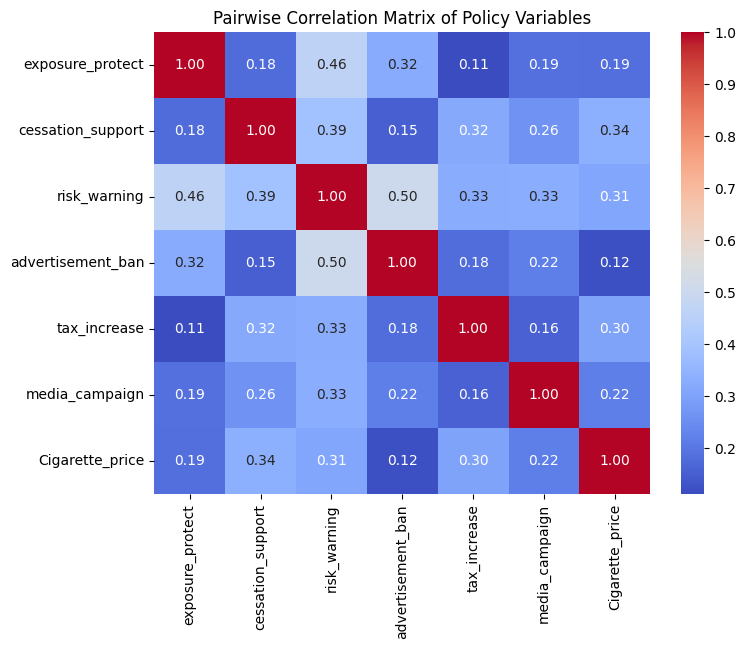

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df[["exposure_protect", "cessation_support", "risk_warning",
                   "advertisement_ban", "tax_increase", "media_campaign", "Cigarette_price"]].corr()

# Plot heatmap for visualization to check which policies are most correlated
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pairwise Correlation Matrix of Policy Variables")
plt.show()

# Highest correlation
#1. risk warning and advertisement ban coef=0.5
#2. risk warning and exposure protection coef=0.46
#3. risk warning and cessation support coeff=0.39
#4. cigarette price and cessation support coeff=0.34
#5. risk warning and tax increase/media campaign coeff=0.33
#6. exposure protectiont and advertisement ban

## Interaction Terms Analysis

In [ ]:
# Test 2 Interaction terms at a time:

import statsmodels.formula.api as smf

# Create interaction terms
df["media_warning"] = df["media_campaign"] * df["risk_warning"]
df["tax_price"] = df["tax_increase"] * df["Cigarette_price"]

# Define Fixed Effects Model with interaction terms
formula = """
Overall_use ~ Cigarette_price + exposure_protect + cessation_support + risk_warning +
              advertisement_ban + tax_increase + media_campaign +
              media_warning + tax_price +
              C(Region) + C(Year)
"""

# Run Fixed Effects Model
model = smf.ols(formula=formula, data=df).fit()

# Print Regression Results
print(model.summary())
# --> "media_warning" is significant--> meaing the policies interact

                            OLS Regression Results                            
Dep. Variable:            Overall_use   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     344.8
Date:                Fri, 21 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:15:13   Log-Likelihood:                -2273.7
No. Observations:                1296   AIC:                             4903.
Df Residuals:                    1118   BIC:                             5823.
Df Model:                         177                                         
Covariance Type:            nonrobust                                         
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [ ]:
# Further 2 interaction terms testing
import statsmodels.formula.api as smf

# Create new interaction terms
df["protect_warning"] = df["exposure_protect"] * df["risk_warning"]
df["protect_adban"] = df["exposure_protect"] * df["advertisement_ban"]

# Define Fixed Effects Model with interaction terms
formula = """
Overall_use ~ Cigarette_price + exposure_protect + cessation_support + risk_warning +
              advertisement_ban + tax_increase + media_campaign +
              protect_warning + protect_adban +
              C(Region) + C(Year)
"""

# Run Fixed Effects Model
model = smf.ols(formula=formula, data=df).fit()

# Print Regression Results
print(model.summary())

#not significant

                            OLS Regression Results                            
Dep. Variable:            Overall_use   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     343.5
Date:                Fri, 21 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:15:13   Log-Likelihood:                -2276.0
No. Observations:                1296   AIC:                             4908.
Df Residuals:                    1118   BIC:                             5828.
Df Model:                         177                                         
Covariance Type:            nonrobust                                         
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [ ]:
# Interaction term testing
import statsmodels.formula.api as smf

# Create new interaction terms
df["cessation_warning"] = df["cessation_support"] * df["risk_warning"]
df["warning_adban"] = df["risk_warning"] * df["advertisement_ban"]

# Define Fixed Effects Model with interaction terms
formula = """
Overall_use ~ Cigarette_price + exposure_protect + cessation_support + risk_warning +
              advertisement_ban + tax_increase + media_campaign +
              cessation_warning + warning_adban +
              C(Region) + C(Year)
"""

# Run Fixed Effects Model
model = smf.ols(formula=formula, data=df).fit()

# Print Regression Results
print(model.summary())

#cessation_warning boarder line significant

                            OLS Regression Results                            
Dep. Variable:            Overall_use   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     344.5
Date:                Fri, 21 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:15:13   Log-Likelihood:                -2274.1
No. Observations:                1296   AIC:                             4904.
Df Residuals:                    1118   BIC:                             5824.
Df Model:                         177                                         
Covariance Type:            nonrobust                                         
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [ ]:
# Interaction term testing
import statsmodels.formula.api as smf

# Create new interaction terms
df["price_adban"] = df["Cigarette_price"] * df["advertisement_ban"]
df["adban_media"] = df["advertisement_ban"] * df["media_campaign"]

# Define Fixed Effects Model with interaction terms
formula = """
Overall_use ~ Cigarette_price + exposure_protect + cessation_support + risk_warning +
              advertisement_ban + tax_increase + media_campaign +
              price_adban + adban_media +
              C(Region) + C(Year)
"""

# Run Fixed Effects Model
model = smf.ols(formula=formula, data=df).fit()

# Print Regression Results
print(model.summary())
# significant advertisment ban and price increase

                            OLS Regression Results                            
Dep. Variable:            Overall_use   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     344.7
Date:                Fri, 21 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:15:14   Log-Likelihood:                -2273.8
No. Observations:                1296   AIC:                             4904.
Df Residuals:                    1118   BIC:                             5823.
Df Model:                         177                                         
Covariance Type:            nonrobust                                         
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [ ]:
# 3 interaction terms were significant
# Test fixed effect multiple regression with 3 interaction terms

# Create interaction terms
df["media_warning"] = df["media_campaign"] * df["risk_warning"]
df["price_adban"] = df["Cigarette_price"] * df["advertisement_ban"]
df["cessation_warning"] = df["cessation_support"] * df["risk_warning"]

# Define Fixed Effects Model with selected interaction terms
formula = """
Overall_use ~ Cigarette_price + exposure_protect + cessation_support + risk_warning +
              advertisement_ban + tax_increase + media_campaign +
              media_warning + price_adban + cessation_warning +
              C(Region) + C(Year)
"""

# Run Fixed Effects Model
model = smf.ols(formula=formula, data=df).fit()

# Print Regression Results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Overall_use   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     344.7
Date:                Fri, 21 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:15:14   Log-Likelihood:                -2269.6
No. Observations:                1296   AIC:                             4897.
Df Residuals:                    1117   BIC:                             5822.
Df Model:                         178                                         
Covariance Type:            nonrobust                                         
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

## Clustering Standard Errors

In [ ]:
# We note great variation in coefficients of variables and interaction terms with changing variables
# Test clusters to represent 'Region'
import statsmodels.formula.api as smf

# Define the Fixed-Effects Model with clustered standard errors
formula = """
Overall_use ~ Cigarette_price + exposure_protect + cessation_support +
              risk_warning + advertisement_ban + tax_increase + media_campaign +
              C(Region) + C(Year)
"""

# Run model with cluster-robust standard errors
model = smf.ols(formula=formula, data=df).fit(
    cov_type='cluster',  # Cluster standard errors
    cov_kwds={'groups': df['Region']}  # Cluster by country/region
)

# Print results
print(model.summary())
# more robust but conservative model, effect of policies reduced

                            OLS Regression Results                            
Dep. Variable:            Overall_use   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     291.8
Date:                Fri, 21 Mar 2025   Prob (F-statistic):          1.54e-106
Time:                        16:15:14   Log-Likelihood:                -2276.8
No. Observations:                1296   AIC:                             4906.
Df Residuals:                    1120   BIC:                             5815.
Df Model:                         175                                         
Covariance Type:              cluster                                         
                                                                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 175, but rank is 14
  warnings.warn('covariance of constraints does not have full '


In [ ]:
# Introduce interaction term in clustered model

import statsmodels.formula.api as smf

# Create interaction term
df["media_warning"] = df["media_campaign"] * df["risk_warning"]

# Define Fixed-Effects Model with clustered standard errors
formula = """
Overall_use ~ Cigarette_price + exposure_protect + cessation_support +
              risk_warning + advertisement_ban + tax_increase + media_campaign +
              media_warning +
              C(Region) + C(Year)
"""

# Run model with cluster-robust standard errors
model = smf.ols(formula=formula, data=df).fit(
    cov_type='cluster',  # Cluster standard errors
    cov_kwds={'groups': df['Region']}  # Cluster by country/region
)

# Print results
print(model.summary())
# Interaction term not significant

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 176, but rank is 15
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:            Overall_use   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     187.0
Date:                Fri, 21 Mar 2025   Prob (F-statistic):           1.71e-93
Time:                        16:15:14   Log-Likelihood:                -2273.9
No. Observations:                1296   AIC:                             4902.
Df Residuals:                    1119   BIC:                             5816.
Df Model:                         176                                         
Covariance Type:              cluster                                         
                                                                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

## Stratifying by Income Groups

In [ ]:
#To Reduce within-group variation stratification by Income Grop
import statsmodels.formula.api as smf

# Define a function to run the fixed-effects model with clustering for each income group
def run_fixed_effects_model(income_group):
    df_subset = df[df["Income_Group"] == income_group]  # Filter dataset for income group

    formula = """
    Overall_use ~ Cigarette_price + exposure_protect + cessation_support +
                  risk_warning + advertisement_ban + tax_increase + media_campaign +
                  C(Region) + C(Year)
    """

    model = smf.ols(formula=formula, data=df_subset).fit(
        cov_type='cluster',  # Cluster standard errors
        cov_kwds={'groups': df_subset['Region']}  # Cluster by region
    )

    print(f"Results for {income_group}:")
    print(model.summary())
    print("\n" + "="*80 + "\n")

# Run the model separately for each income group
for group in ["HIC", "UMIC", "LMIC", "LIC"]:
    run_fixed_effects_model(group)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 70, but rank is 14
  warnings.warn('covariance of constraints does not have full '


Results for HIC:
                            OLS Regression Results                            
Dep. Variable:            Overall_use   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     345.9
Date:                Fri, 21 Mar 2025   Prob (F-statistic):           5.34e-49
Time:                        16:15:14   Log-Likelihood:                -803.12
No. Observations:                 456   AIC:                             1748.
Df Residuals:                     385   BIC:                             2041.
Df Model:                          70                                         
Covariance Type:              cluster                                         
                                                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 57, but rank is 14
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 55, but rank is 14
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:            Overall_use   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     3162.
Date:                Fri, 21 Mar 2025   Prob (F-statistic):           1.68e-57
Time:                        16:15:15   Log-Likelihood:                -623.06
No. Observations:                 336   AIC:                             1358.
Df Residuals:                     280   BIC:                             1572.
Df Model:                          55                                         
Covariance Type:              cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 32, but rank is 14
  warnings.warn('covariance of constraints does not have full '


## Stratifying by Continental Classification

In [ ]:
# Merge North America & Latin America into "Americas"
df["Continental_Classification"] = df["Continental_Classification"].replace(
    {"North America": "Americas", "Latin America & Caribbean": "Americas"}
)

In [ ]:
# Stratified by International Classification

import statsmodels.formula.api as smf

def run_fixed_effects_model(continental_class):
    df_subset = df[df["Continental_Classification"] == continental_class]  # Filter dataset

    # Decide whether to cluster or use robust errors
    if df_subset["Region"].nunique() < 10:  # Too few regions for clustering
        cov_type = "HC3"  # Use heteroskedasticity-robust standard errors
        cluster_kwds = {}
        print(f"Using robust standard errors for {continental_class} (not enough regions for clustering)")
    else:
        cov_type = "cluster"
        cluster_kwds = {'groups': df_subset['Region']}

    # Define model
    formula = """
    Overall_use ~ Cigarette_price + exposure_protect + cessation_support +
                  risk_warning + advertisement_ban + tax_increase + media_campaign +
                  C(Region) + C(Year)
    """

    model = smf.ols(formula=formula, data=df_subset).fit(
        cov_type=cov_type,
        cov_kwds=cluster_kwds if cov_type == "cluster" else None
    )

    print(f"Results for {continental_class}:")
    print(model.summary())
    print("\n" + "="*80 + "\n")

# Run the model for each continent (with merged Americas)
for continent in df["Continental_Classification"].unique():
    run_fixed_effects_model(continent)


Using robust standard errors for South Asia (not enough regions for clustering)
Results for South Asia:
                            OLS Regression Results                            
Dep. Variable:            Overall_use   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     200.8
Date:                Fri, 21 Mar 2025   Prob (F-statistic):           1.74e-35
Time:                        16:15:15   Log-Likelihood:                -103.23
No. Observations:                  64   AIC:                             250.5
Df Residuals:                      42   BIC:                             298.0
Df Model:                          21                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
--------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 60, but rank is 14
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 30, but rank is 14
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:            Overall_use   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     298.5
Date:                Fri, 21 Mar 2025   Prob (F-statistic):           1.32e-16
Time:                        16:15:15   Log-Likelihood:                -174.34
No. Observations:                 136   AIC:                             410.7
Df Residuals:                     105   BIC:                             501.0
Df Model:                          30                                         
Covariance Type:              cluster                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 38, but rank is 14
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 40, but rank is 14
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:            Overall_use   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     284.2
Date:                Fri, 21 Mar 2025   Prob (F-statistic):           3.87e-23
Time:                        16:15:15   Log-Likelihood:                -287.70
No. Observations:                 200   AIC:                             653.4
Df Residuals:                     161   BIC:                             782.0
Df Model:                          38                                         
Covariance Type:              cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 51, but rank is 14
  warnings.warn('covariance of constraints does not have full '


## Gender-Specific Policy Effects

In [ ]:
# Investigate the impact of policies on gender specific tobacco use
# 1. FE cluster Model
# 2. FE clustered Model with interaction term
# 3. Stratified by Income Group
#4. Stratified by Continental Class

#1. FE cluster Model for male and female tobacco prevalence

import statsmodels.formula.api as smf

# Define Fixed-Effects Model with clustered standard errors for Male tobacco prevalence
formula_male = """
Male ~ Cigarette_price + exposure_protect + cessation_support +
        risk_warning + advertisement_ban + tax_increase + media_campaign +
        C(Region) + C(Year)
"""

# Define Fixed-Effects Model with clustered standard errors for Female tobacco prevalence
formula_female = """
Female ~ Cigarette_price + exposure_protect + cessation_support +
          risk_warning + advertisement_ban + tax_increase + media_campaign +
          C(Region) + C(Year)
"""

# Run Male Model
model_male = smf.ols(formula=formula_male, data=df).fit(
    cov_type='cluster',
    cov_kwds={'groups': df['Region']}  # Cluster by region
)

# Run Female Model
model_female = smf.ols(formula=formula_female, data=df).fit(
    cov_type='cluster',
    cov_kwds={'groups': df['Region']}  # Cluster by region
)

# Print Results
print("### Male Tobacco Prevalence Model ###")
print(model_male.summary())

print("\n### Female Tobacco Prevalence Model ###")
print(model_female.summary())


### Male Tobacco Prevalence Model ###
                            OLS Regression Results                            
Dep. Variable:                   Male   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     2317.
Date:                Fri, 21 Mar 2025   Prob (F-statistic):          1.04e-177
Time:                        16:15:15   Log-Likelihood:                -2583.4
No. Observations:                1296   AIC:                             5519.
Df Residuals:                    1120   BIC:                             6428.
Df Model:                         175                                         
Covariance Type:              cluster                                         
                                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 175, but rank is 14
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 175, but rank is 14
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:                 Female   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1386.
Date:                Fri, 21 Mar 2025   Prob (F-statistic):          7.21e-160
Time:                        16:15:15   Log-Likelihood:                -2386.1
No. Observations:                1296   AIC:                             5124.
Df Residuals:                    1120   BIC:                             6034.
Df Model:                         175                                         
Covariance Type:              cluster                                         
                                                                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [ ]:
# 2. FE clustered Model with interaction term

import statsmodels.formula.api as smf

# Create interaction term
df["media_warning"] = df["media_campaign"] * df["risk_warning"]

# Define function to run Fixed-Effects Model for both Male and Female tobacco prevalence
def run_gender_models(df):
    for gender in ["Male", "Female"]:
        formula = f"""
        {gender} ~ Cigarette_price + exposure_protect + cessation_support +
                    risk_warning + advertisement_ban + tax_increase + media_campaign +
                    media_warning +
                    C(Region) + C(Year)
        """

        # Run model with cluster-robust standard errors
        model = smf.ols(formula=formula, data=df).fit(
            cov_type='cluster',
            cov_kwds={'groups': df['Region']}
        )

        # Print results
        print(f"### {gender} Tobacco Prevalence Model ###")
        print(model.summary())

# Run models for both genders
run_gender_models(df)



### Male Tobacco Prevalence Model ###
                            OLS Regression Results                            
Dep. Variable:                   Male   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     749.7
Date:                Fri, 21 Mar 2025   Prob (F-statistic):          1.78e-140
Time:                        16:15:16   Log-Likelihood:                -2579.9
No. Observations:                1296   AIC:                             5514.
Df Residuals:                    1119   BIC:                             6428.
Df Model:                         176                                         
Covariance Type:              cluster                                         
                                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 176, but rank is 15
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 176, but rank is 15
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:                 Female   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     961.1
Date:                Fri, 21 Mar 2025   Prob (F-statistic):          4.85e-149
Time:                        16:15:16   Log-Likelihood:                -2385.0
No. Observations:                1296   AIC:                             5124.
Df Residuals:                    1119   BIC:                             6039.
Df Model:                         176                                         
Covariance Type:              cluster                                         
                                                                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [ ]:
# 3. Stratified by Income Group

import statsmodels.formula.api as smf

# Define a function to run the fixed-effects model with clustering for each income group
def run_fixed_effects_model(income_group, dependent_variable):
    df_subset = df[df["Income_Group"] == income_group]  # Filter dataset for income group

    formula = f"""
    {dependent_variable} ~ Cigarette_price + exposure_protect + cessation_support +
                          risk_warning + advertisement_ban + tax_increase + media_campaign +
                          C(Region) + C(Year)
    """

    model = smf.ols(formula=formula, data=df_subset).fit(
        cov_type='cluster',  # Cluster standard errors
        cov_kwds={'groups': df_subset['Region']}  # Cluster by region
    )

    print(f"Results for {income_group} ({dependent_variable}):")
    print(model.summary())
    print("\n" + "="*80 + "\n")

# Run the model separately for each income group for both Male and Female tobacco prevalence
for group in ["HIC", "UMIC", "LMIC", "LIC"]:
    for outcome in ["Male", "Female"]:
        run_fixed_effects_model(group, outcome)

Results for HIC (Male):
                            OLS Regression Results                            
Dep. Variable:                   Male   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     170.0
Date:                Fri, 21 Mar 2025   Prob (F-statistic):           1.56e-40
Time:                        16:15:16   Log-Likelihood:                -868.90
No. Observations:                 456   AIC:                             1880.
Df Residuals:                     385   BIC:                             2173.
Df Model:                          70                                         
Covariance Type:              cluster                                         
                                                                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 70, but rank is 14
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 70, but rank is 14
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 57, but rank is 14
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:                   Male   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     297.9
Date:                Fri, 21 Mar 2025   Prob (F-statistic):           4.88e-38
Time:                        16:15:16   Log-Likelihood:                -668.31
No. Observations:                 352   AIC:                             1453.
Df Residuals:                     294   BIC:                             1677.
Df Model:                          57                                         
Covariance Type:              cluster                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 57, but rank is 14
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 55, but rank is 14
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 55, but rank is 14
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:                 Female   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     2110.
Date:                Fri, 21 Mar 2025   Prob (F-statistic):           6.58e-54
Time:                        16:15:16   Log-Likelihood:                -671.10
No. Observations:                 336   AIC:                             1454.
Df Residuals:                     280   BIC:                             1668.
Df Model:                          55                                         
Covariance Type:              cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 32, but rank is 14
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 32, but rank is 14
  warnings.warn('covariance of constraints does not have full '


In [ ]:
#4. Stratified by Continental Class
import statsmodels.formula.api as smf

def run_fixed_effects_model(continental_class, gender):
    df_subset = df[df["Continental_Classification"] == continental_class]  # Filter dataset

    # Decide whether to cluster or use robust errors
    if df_subset["Region"].nunique() < 10:  # Too few regions for clustering
        cov_type = "HC3"  # Use heteroskedasticity-robust standard errors
        cluster_kwds = {}
        print(f"Using robust standard errors for {continental_class} (not enough regions for clustering)")
    else:
        cov_type = "cluster"
        cluster_kwds = {'groups': df_subset['Region']}

    # Define model for male or female tobacco prevalence
    formula = f"""
    {gender} ~ Cigarette_price + exposure_protect + cessation_support +
                risk_warning + advertisement_ban + tax_increase + media_campaign +
                C(Region) + C(Year)
    """

    model = smf.ols(formula=formula, data=df_subset).fit(
        cov_type=cov_type,
        cov_kwds=cluster_kwds if cov_type == "cluster" else None
    )

    print(f"Results for {gender} in {continental_class}:")
    print(model.summary())
    print("\n" + "="*80 + "\n")

# Run the model separately for male and female tobacco prevalence across each continent
for continent in df["Continental_Classification"].unique():
    for gender in ["Male", "Female"]:  # Adjust column names if needed
        run_fixed_effects_model(continent, gender)


Using robust standard errors for South Asia (not enough regions for clustering)
Results for Male in South Asia:
                            OLS Regression Results                            
Dep. Variable:                   Male   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     166.0
Date:                Fri, 21 Mar 2025   Prob (F-statistic):           8.84e-34
Time:                        16:15:17   Log-Likelihood:                -103.30
No. Observations:                  64   AIC:                             250.6
Df Residuals:                      42   BIC:                             298.1
Df Model:                          21                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 60, but rank is 14
  warnings.warn('covariance of constraints does not have full '


Results for Male in Europe & Central Asia:
                            OLS Regression Results                            
Dep. Variable:                   Male   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     425.3
Date:                Fri, 21 Mar 2025   Prob (F-statistic):           1.01e-43
Time:                        16:15:17   Log-Likelihood:                -680.34
No. Observations:                 376   AIC:                             1483.
Df Residuals:                     315   BIC:                             1722.
Df Model:                          60                                         
Covariance Type:              cluster                                         
                                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 60, but rank is 14
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 30, but rank is 14
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 30, but rank is 14
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:                 Female   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     3458.
Date:                Fri, 21 Mar 2025   Prob (F-statistic):           4.25e-25
Time:                        16:15:17   Log-Likelihood:                -103.85
No. Observations:                 136   AIC:                             269.7
Df Residuals:                     105   BIC:                             360.0
Df Model:                          30                                         
Covariance Type:              cluster                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 38, but rank is 14
  warnings.warn('covariance of constraints does not have full '


Results for Female in Americas:
                            OLS Regression Results                            
Dep. Variable:                 Female   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1229.
Date:                Fri, 21 Mar 2025   Prob (F-statistic):           9.78e-31
Time:                        16:15:17   Log-Likelihood:                -241.31
No. Observations:                 200   AIC:                             560.6
Df Residuals:                     161   BIC:                             689.3
Df Model:                          38                                         
Covariance Type:              cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 38, but rank is 14
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 40, but rank is 14
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 40, but rank is 14
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:                 Female   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     1025.
Date:                Fri, 21 Mar 2025   Prob (F-statistic):           5.92e-32
Time:                        16:15:17   Log-Likelihood:                -375.14
No. Observations:                 216   AIC:                             832.3
Df Residuals:                     175   BIC:                             970.7
Df Model:                          40                                         
Covariance Type:              cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 51, but rank is 14
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:                   Male   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1246.
Date:                Fri, 21 Mar 2025   Prob (F-statistic):           5.12e-45
Time:                        16:15:17   Log-Likelihood:                -581.83
No. Observations:                 304   AIC:                             1268.
Df Residuals:                     252   BIC:                             1461.
Df Model:                          51                                         
Covariance Type:              cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 51, but rank is 14
  warnings.warn('covariance of constraints does not have full '
